## Chapter 10. 파이썬 성능 개선
> 성과에 부응하기 위해 기대를 낮추면 된다.  
기대에 부응하기 위해 성과 수준을 높여야 한다.  
-랄프 마스턴(Ralph Maston)

파이썬은 상대적으로 느린 프로그래밍 언어고 금융 분야에서 사용되는 계산량이 많은 작업에 적합하지 않다는 것은 오래된 편견입니다. 파이썬은 인터프리터 언어고 특히 반복 작업에서 느린데 금융 알고리즘에는 반복 작업이 많이 쓰이니 금융 알고리즘 구현에 적합하지 않다는 논리죠. 다시 말해 C 또는 C++ 같은 컴파일 언어가 반복 작업 실행이 빠르고 금융 알고리즘 구현에 적합하다고 주장하는 겁니다.  
물론 파이썬 코드 실행 속도가 느리거나 여러 가지 응용 분야에 적합하지 않을 수도 있습니다. 이 장에서는 금융 분야에서 만나게 되는 전형적인 작업이나 알고리즘에서 어떻게 속도를 개선할 수 있는지 살펴봅니다. 또 적절한 자료구조를 선택하는 법, 올바른 패러다임을 선택하는 법 그리고 좋은 성능 개선 패키지를 사용하는 법을 보입니다. 파이썬은 사실 컴파일 등이 가능한 프로그래밍 언어이기 때문에 컴파일 언어와도 경쟁할 수 있습니다.  
이 장에서는 코드 속도 개선을 위한 다음과 같은 방법론을 소개합니다.  
* 벡터화: 지금까지 많이 언급된 기능 중 하나인 파이썬의 벡터화 기능을 사용합니다.
* 동적 컴파일: `Numba` 패키지를 사용하면 LLVM 기술을 이요하여 순수 파이썬 코드를 동적으로 컴파일할 수 있습니다.  
* 정적 컴파일: `Cython`은 파이썬 패키지는 아니지만 파이썬과 C를 결합한 복합 언어입니다. `Cython`을 쓰면 정적 자료형 선언을 통해 변경된 코드를 정적으로 컴파일할 수 있습니다.  
* 멀티프로세싱: 파이썬 멀티프로세싱 모듈을 사용하면 쉽고 간단하게 코드를 병렬로 실행할 수 있습니다. 

이 장에서 소개하는 주제는 다음과 같습니다.  
* 반복문: 파이썬 반복문 속도를 개선하는 방법을 소개합니다.
* 알고리즘: 피보나치 수 생성과 같이 성능 평가에 흔히 사용되는 표준 수학 알고리즘을 다룹니다.
* 이항 트리: 아주 널리 쓰이는 이항 옵션 가격결정 모형은 좀 더 복잡한 금융 알고리즘과 관련된 흥미 있는 케이스 스터디가 가능한 금융 모형입니다.
* 몬테카를로 시뮬레이션: 마찬가지로 몬테카를로 시뮬레이션도 금융 분야에서 가치 평가나 위험 관리에 많이 사용됩니다. 계산량이 막대하기 때문에 오랫동안 C나 C++ 언어의 영역으로 여겨진 부분입니다.
* 재귀적 pandas 알고리즘: 금융 시계열 데이터에 기반한 재귀적 알고리즘의 속도를 높일 수 있는 방법을 설명합니다. 특히 지수가중 이동평균(Exponentially Weighted Moving Average, EWMA)을 계산하는 알고리즘을 여러 방법으로 구현합니다.

## 10.1 반복문
작업 목표는 간단합니다. 대량의 난수를 만들고 그 난수값의 평균을 반환하는 함수를 만듭니다. 실행 속도는 `%time`과 `%timeit` 매직 명령으로 측정합니다.
### 10.1.1 파이썬
일단 천천히 돌아가는 버전부터 살펴보죠. 순수 파이썬으로 이런 함수를 만들면 `average_py()`처럼 됩니다.

In [1]:
import random

In [2]:
def average_py(n):
    s = 0 # s 변수값 초기화
    for i in range(n):
        s += random.random() # 0과 1 사이의 균일 분포 난수를 s에 포함
    return s / n # 평균값 반환

In [3]:
n = 10000000 # 루프 반복 횟수 정의

In [4]:
%time average_py(n) # 함수를 한 번 실행하는 시간

CPU times: total: 953 ms
Wall time: 988 ms


0.4999863662174375

In [5]:
%timeit average_py(n) # 함수를 여러 번 실행하는 시간

1.07 s ± 366 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%time sum([random.random() for _ in range(n)]) / n # 함수 대신 복합 리스트문 사용

CPU times: total: 1.94 s
Wall time: 1.95 s


0.49993838894082626

이 속도가 다른 방법론에 대한 기준 벤치마크 속도가 되겠습니다.  

### 10.1.2 NumPy
넘파이의 강점은 벡터화 기능입니다. 형식적으로 파이썬의 수준의 루프는 없어지고 더 깊은 단계에서 넘파이를 제공하는 최적화되고 컴파일된 루프를 사용합니다. `average_np()` 함수가 이런 방식을 사용합니다.

In [7]:
import numpy as np

In [8]:
def average_np(n):
    s = np.random.random(n) # 난수를 한 번에 발생(파이썬 루프 없음)
    return s.mean() # 평균값 반환

In [9]:
%time average_np(n)

CPU times: total: 172 ms
Wall time: 166 ms


0.5000841084355959

In [10]:
%timeit average_np(n)

131 ms ± 5.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
s = np.random.random(n) # 생성된 ndarray 객체에 사용된 바이트 수
s.nbytes

80000000

거의 10배 정도 속도가 개선되었죠? 하지만 그 대신 메모리 사용량이 높아지는 대가를 치러야 합니다. 넘파이가 컴파일 레이어에서 처리하는 데이터를 미리 할당하기 떄문입니다. 따라서 순차적으로 데이터를 처리할 수 있는 방법은 없습니다. 알고리즘이나 문제에 따라서는 이렇게 늘어난 메모리가 과다하게 커질 수도 있습니다.  
> **CAUTION**_ 벡터화와 메모리  
넘파이로 벡터화한 코드를 짜면 문법이 간단해지고 속도도 개선되기 때문에 매력적입니다. 그러나 이러한 개선은 더 많은 메모리 사용이라는 비용을 요구합니다.

### 10.1.3 Numba
`Numba`(https://numba.pydata.org)는 LLVM을 사용하여 순수한 파이썬 코드를 동적으로 컴파일하는 패키지입니다. 지금과 같이 간단한 경우에는 아주 쉽게 동적 컴파일을 할 수 있습니다. 이렇게 만든 `average_nb()`는 파이썬에서 바로 호출할 수 있습니다.

In [12]:
import numba

In [13]:
average_nb = numba.jit(average_py) # Numba 함수 생성

In [14]:
%time average_nb(n) # 실행 시간에 컴파일이 되므로 약간의 오버헤드가 있을 수 있습니다.

CPU times: total: 422 ms
Wall time: 429 ms


0.49990829708967116

In [15]:
%time average_nb(n) # 두 번째로 실행하면 속도가 빨라집니다.

CPU times: total: 78.1 ms
Wall time: 80.1 ms


0.4998877282878201

In [16]:
%timeit average_nb(n)

90.3 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


순수 파이썬과 `Numba`를 결합하면 넘파이보다 빠르고 메모리 효율성 문제도 해결할 수 있습니다. 또한 간단한 경우에는 프로그래밍에 들어가는 부담도 없습니다.  
> **NOTE**_ 공짜 점심은 없다  
사용 편의성을 고려하고 파이썬 코드와 컴파일된 코드의 성능을 비교해보면 `Numba`를 활용하는 것이 마치 마법처럼 느껴질 수 있습니다. 하지만 `Numba`를 사용하는 것이 적절하지 않고 성능 개선이 미비하거나 아예 성능을 개선할 수 없는 경우도 많습니다.  

### 10.1.4 Cython
`Cython`은 파이썬 코드를 정적으로 컴파일합니다. 하지만 성능을 많이 개선하려면 코드를 고쳐야 하기 때문에 `Numba`에 비해 사용법이 단순하지 않습니다. 일단 다음에 나온 `Cython` 함수 `average_cy1()`을 보죠. 여기서는 사용한 변수에 대해 정적으로 자료형을 선언했습니다.

In [17]:
%load_ext Cython

In [18]:
%%cython -a
import random # random 모듈을 Cython 내에서 임포트
# 변수 n, i, s에 대해 정적 자료형 선언
def average_cy1(int n):
    cdef int i
    cdef float s = 0
    for i in range(n):
        s += random.random()
    return s / n

In [19]:
%time average_cy1(n)

CPU times: total: 844 ms
Wall time: 840 ms


0.5000690221786499

In [20]:
%timeit average_cy1(n)

776 ms ± 57.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


어느 정도 속도 개선이 있지만 넘파이 버전은 아니죠? `Numba` 버전만큼 하려고 해도 어느 정도 `Cython` 최적화가 필요합니다.

In [21]:
%%cython
from libc.stdlib cimport rand # 난수 생성기를 C에서 임포트
# 난수 스케일링에 필요한 상수를 임포트
cdef extern from 'limits.h':
    int INT_MAX
cdef int i
cdef float rn
for i in range(5):
    rn = rand() / INT_MAX # 스케일링된 구간 (0, 1) 사이의 균일 분포 난수 추가
    print(rn)

1.2555159628391266e-05
1.1391937732696533e-05
2.6565976440906525e-06
1.3106036931276321e-05
1.0841060429811478e-05


In [22]:
%%cython -a
from libc.stdlib cimport rand # 난수 생성기를 C에서 임포트
# 난수 스케일링에 필요한 상수를 임포트
cdef extern from 'limits.h':
    int INT_MAX
def average_cy2(int n):
    cdef int i
    cdef float s = 0
    for i in range(n):
        s += rand() / INT_MAX # 스케일링된 구간 (0, 1) 사이의 균일 분포 난수 추가
    return s / n

In [23]:
%time average_cy2(n)

CPU times: total: 234 ms
Wall time: 226 ms


7.628993898833869e-06

In [24]:
%timeit average_cy2(n)

208 ms ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


좀 더 최적화된 버전인 `average_cy2()` 함수는 `Numba` 버전보다는 빠릅니다. 하지만 여전히 노력이 많이 들어가죠. 넘파이 버전보다 비교하면 `Cython`은 원래 루프 버전의 메모리 효율성도 가지고 있습니다.  
> **TIP** Cython = Python + C  
`Cython`은 성능 개선을 위해 개발자가 원하는 만큼 코드를 수정할 수 있습니다. 예를 들어 처음에는 순수 파이썬 버전에서 시작해 조금씩 코드에 C를 추가할 수 있습니다. 적절한 인수를 사용하여 컴파일 단계 자체를 최적화하는 것도 가능합니다.

## 10.2 알고리즘
이 절에서는 앞 절에서 익힌 성능 개선 방법을 몇 가지 잘 알려진 수학 문제와 알고리즘에 적용해보겠습니다. 이 알고리즘들은 성능 벤치마크에 자주 사용됩니다.  

### 10.2.1 소수 확인
소수(prime number)는 1보다 큰 자연수 중에서 약수가 1과 자기 자신뿐인 수를 말하며, 이론 수학뿐만 아니라 응용 전산학과 암호학에서도 중요한 역할을 합니다. 소수인지 아닌지를 증명하기가 어렵기 때문에 큰 소수를 찾는 일은 쉽지 않습니다. 유일한 방법은 약수 중에 1이 아닌 수가 있는지 아닌지 확인하는 것뿐입니다.  
#### 파이썬
어떤 수가 소수인지 확인하는 알고리즘 구현법은 다양합니다. 다음 파이썬 코드는 알고리즘 관점에서 **최적은 아니지만 꽤 효율적인** 방법입니다. 하지만 큰 소수에 대해서는 실행 시간이 길어지죠.

In [25]:
def is_prime(I):
    if I % 2 == 0: return False
    for i in range(3, int(I ** 0.5) + 1, 2):
        if I % i == 0: return False
    return True

In [26]:
n = int(1e8 + 3) #
n

100000003

In [27]:
%time is_prime(n)

CPU times: total: 0 ns
Wall time: 0 ns


False

In [28]:
p1 = int(1e8 + 7) #
p1

100000007

In [29]:
%time is_prime(p1)

CPU times: total: 0 ns
Wall time: 0 ns


True

In [30]:
p2 = 10010910012916

In [31]:
p2.bit_length()

44

In [32]:
%time is_prime(p2)

CPU times: total: 0 ns
Wall time: 0 ns


False

#### Numba
`is_prime()` 함수의 알고리즘에 루프 구조가 있기 때문에 `Numba`로 동적 컴파일을 할 수 있습니다. 코딩 부담은 적지만 성능 개선은 상당합니다.

In [33]:
is_prime_nb = numba.jit(is_prime)

In [34]:
%time is_prime_nb(n) # 첫 호출에는 컴파일 부담이 있습니다.

CPU times: total: 125 ms
Wall time: 129 ms


False

In [35]:
%time is_prime_nb(n) # 두 번째 호출부터는 속도 개선이 눈에 띕니다.

CPU times: total: 0 ns
Wall time: 0 ns


False

In [36]:
%time is_prime_nb(p1)

CPU times: total: 0 ns
Wall time: 0 ns


True

In [37]:
%time is_prime_nb(p2) # 더 큰 소수에 대한 성능 개선이 큽니다.

CPU times: total: 0 ns
Wall time: 0 ns


False

#### Cython
`Cython` 사용법도 어렵지 않습니다. 자료형 선언을 하지 않고 `Cython`을 사용하기만 해도 코드 속도를 개선할 수 있습니다.

In [38]:
%%cython
def is_prime_cy1(I):
    if I % 2 == 0: return False
    for i in range(3, int(I ** 0.5) + 1, 2):
        if I % i == 0: return False
    return True

In [39]:
%timeit is_prime(p1)

435 µs ± 28.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [40]:
%timeit is_prime_cy1(p1)

164 µs ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


하지만 정적 자료형 선언까지 한다면 진짜 성능 개선이 이루어집니다. `Cython` 버전은 `Numba` 버전보다 속도가 빠릅니다.

In [41]:
%%cython
def is_prime_cy2(long I):
    cdef long i
    if I % 2 == 0: return False
    for i in range(3, int(I ** 0.5) + 1, 2):
        if I % i == 0: return False
    return True

In [42]:
%timeit is_prime_cy2(p1)

8.68 µs ± 173 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


#### 멀티프로세싱
지금까지는 모든 최적화 노력이 순차적 실행 코드를 대상으로 이루어졌습니다. 소수를 확인하는 경우에는 동시에 여러 개의 수를 확인할 수도 있습니다. `multiprocessing` 모듈을 사용하면 코드 실행 속도를 더 빠르게 할 수 있습니다. 이 모듈은 여러 개의 파이썬 프로세스를 만들고 병렬도 실행시킵니다. 사용 방법도 간단하고 단순합니다. 먼저 `mp.Pool` 객체에 여러 개의 프로세스를 설정한 후 확인하려는 소수들을 넘겨주기만 하면 됩니다.

In [43]:
import multiprocessing as mp

In [44]:
pool = mp.Pool(processes=4) # mp.Pool 객체에 여러 개의 프로세스를 만듭니다.

In [45]:
# jupyter notebook 환경에서는 실행 불가. 예시 코드만 기록합니다.
# 해당 코드를 실행하려면 스크립트를 .py로 내보내기 한 후에 실행해야 합니다.
# 단, if __name__ = '__main__': 조건문을 넣어주셔서 실행해야 오류가 발생하지 않습니다.
# pool.map(is_prime, 10 * [p1]) # 함수에 넣을 소수의 리스트 객체

In [46]:
# pool.map(is_prime_nb, 10 * [p2])

> **TIP** 병렬 프로세싱  
같은 유형의 다른 문제를 여러 개 풀어야 하는 경우에는 병렬 프로세싱을 고려해야 합니다. 코어가 많고 메모리가 충분한 강력한 하드웨어에서는 효과가 아주 클 수 있습니다. `multiprocessing` 모듈은 파이썬 표준 라이브러리이므로 사용하기도 쉽습니다.

### 10.2.2 피보나치 수
피보나치 수와 수열은 간단한 알고리즘으로 계산할 수 있습니다. 숫자 1 두 개로 시작해서 다음 피보나치 수는 앞선 수 두 개의 합이 됩니다. 따라서 수열은 1, 1, 2, 3, 5, 8, 13, 21, ...과 같아집니다. 여기에서는 재귀적인 방법과 반복적인 방법 두 가지 구현법을 분석해봅니다.  

#### 재귀 알고리즘
일반적인 파이썬 루프와 마찬가지로 파이썬에서 재귀함수 구현은 보통 느립니다. 더군다나 최종 결과에 이르기까지 자기 자신 함수를 **아주 많이** 호출해야 하죠. `fib_rec_py1()` 함수는 이러한 구현법을 보입니다. 이 경우에 `Numba`는 실행 속도를 개선할 수 없습니다. 하지만 `Cython`에서는 정적 자료형 선언만 해도 큰 속도 향상을 보입니다.

In [47]:
def fib_rec_py1(n):
    if n < 2:
        return n
    else:
        return fib_rec_py1(n - 1) + fib_rec_py1(n - 2)

In [48]:
%time fib_rec_py1(35)

CPU times: total: 4.14 s
Wall time: 4.2 s


9227465

In [49]:
fib_rec_nb = numba.jit(fib_rec_py1)

In [50]:
%time fib_rec_nb(35)

C:\Users\tjk\AppData\Local\Temp\ipykernel_10568\990881348.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fib_rec_py1" failed type inference due to: Untyped global name 'fib_rec_py1': Cannot determine Numba type of <class 'function'>

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_10568\990881348.py", line 5:
<source missing, REPL/exec in use?>

  def fib_rec_py1(n):
c:\Users\tjk\AppData\Local\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "fib_rec_py1" was compiled in object mode without forceobj=True.

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_10568\990881348.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
c:\Users\tjk\AppData\Local\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this 

CPU times: total: 3.47 s
Wall time: 3.49 s


9227465

In [51]:
%%cython
def fib_rec_cy(n):
    if n < 2:
        return n
    else:
        return fib_rec_cy(n - 1) + fib_rec_cy(n - 2)

In [52]:
%time fib_rec_cy(35)

CPU times: total: 812 ms
Wall time: 832 ms


9227465

재귀 알고리즘의 큰 문제는 중간 결과를 캐싱하지 않고 다시 계산한다는 것입니다. 이 문제를 해결하는 데 중간 결과를 캐싱하기 위한 데코레이터를 사용할 수 있습니다. 이렇게 하면 속도가 몇 배로 향상됩니다.

In [53]:
from functools import lru_cache as cache

In [54]:
@cache(maxsize=None) # 중간 결과를 캐싱
def fib_rec_py2(n):
    if n < 2:
        return n
    else:
        return fib_rec_py2(n - 1) + fib_rec_py2(n - 2)

In [55]:
# 이 경우에는 엄청난 속도 향상이 가능합니다.
%time fib_rec_py2(35)

CPU times: total: 0 ns
Wall time: 0 ns


9227465

In [56]:
%time fib_rec_py2(80)

CPU times: total: 0 ns
Wall time: 79.2 µs


23416728348467685

#### 반복 알고리즘
$n$번째 피보나치 수를 계산하는 알고리즘이 반드시 재귀적일 필요는 없습니다. 다음 코드는 순수 파이썬으로 반복적 구현을 한 것입니다. 재귀적 구현에 캐싱을 더한 것보다 빠릅니다. 이 경우에는 `Numba`도 속도 개선이 가능합니다. 하지만 여전히 `Cython` 버전이 가장 빠르군요.

In [57]:
def fib_it_py(n):
    x, y = 0, 1
    for i in range(1, n + 1):
        x, y = y, x + y
    return x

In [58]:
%time fib_it_py(80)

CPU times: total: 0 ns
Wall time: 0 ns


23416728348467685

In [59]:
fib_it_nb = numba.jit(fib_it_py)

In [60]:
%time fib_it_nb(80) # 첫 컴파일

CPU times: total: 78.1 ms
Wall time: 54.7 ms


23416728348467685

In [61]:
%time fib_it_nb(80)

CPU times: total: 0 ns
Wall time: 0 ns


23416728348467685

In [62]:
%%cython
def fib_it_cy1(int n):
    cdef long i
    cdef long x = 0, y = 1
    for i in range(1, n+1):
        x, y = y, x + y
    return x

In [63]:
%time fib_it_cy1(80)

CPU times: total: 0 ns
Wall time: 0 ns


-285007387

속도가 충분히 빨라졌는데도 80번쨰 피보나치 수를 계산하는 이유가 궁금할 것입니다.(오버플로우까지 발생) 문제는 자료형입니다. 파이썬은 기본적으로 아주 큰 수를 다룰 수 있지만 컴파일된 버전에서는 그렇지 않습니다. 하지만 `Cython`에서는 64비트 부동소수점이 허락하는 가장 큰 수보다도 더 큰 수를 다룰 수 있는 특별한 자료형을 쓸 수 있습니다.

In [64]:
# 파이썬 버전이 빠르고 정확
%time fn = fib_rec_py2(150)
print(fn)

CPU times: total: 0 ns
Wall time: 427 µs
9969216677189303386214405760200


In [65]:
fn.bit_length() # 결과로 나온 정수가 103비트 수준

103

In [66]:
# Numba와 Cython 버전이 더 빠르지만 부정확
%time fn = fib_it_nb(150)
print(fn)
fn.bit_length()

CPU times: total: 0 ns
Wall time: 0 ns
6792540214324356296


63

In [67]:
%time fn = fib_it_cy1(150)
print(fn)
fn.bit_length()

CPU times: total: 0 ns
Wall time: 0 ns
626779336


30

In [68]:
# 128비트 정수형 객체를 임포트하여 사용
# 이것도 수정 필요
'''%%cython
cdef extern from *:
    ctypedef int int128 '__int128_t'  
def fib_it_cy2(int n):
    cdef int128 i  
    cdef int128 x = 0, y = 1  
    for i in range(1, n + 1):
        x, y = y, x + y
    return x'''

"%%cython\ncdef extern from *:\n    ctypedef int int128 '__int128_t'  \ndef fib_it_cy2(int n):\n    cdef int128 i  \n    cdef int128 x = 0, y = 1  \n    for i in range(1, n + 1):\n        x, y = y, x + y\n    return x"

### 10.2.3 원주율
마지막 알고리즘은 몬테카를로 시뮬레이션에 기반하여 원주율($\pi$)의 값을 계산하는 것입니다. 기본적인 아이디어는 원의 면적 $A$가 공식 $A=\pi r^2$으로 주어진다는 것입니다. 따라서 $\pi=A/r^2$겠죠? 반지름 $r=1$인 단위원의 경우에는 $\pi=A$가 됩니다. 알고리즘의 기본 아이디어는 -1부터 1까지의 좌표 $\left(x, y\right)$에서 난수 점을 시뮬레이션하는 것입니다. 길이가 2이므로 정사각형의 면적은 정확하게 4입니다. 같은 중심을 가지는 단위원과 이 사각형 면적의 비율을 몬테카를로 시뮬레이션으로 구합니다. 즉 사각형 내부의 점의 개수를 세고 단위원 내부의 점의 개수를 세어서 나눕니다. 시뮬레이션 결과는 아래 그림과 같습니다.

In [69]:
import random
import numpy as np
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

C:\Users\tjk\AppData\Local\Temp\ipykernel_10568\1478729055.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [70]:
rn = [(random.random() * 2 - 1, random.random() * 2 -1) for _ in range(500)]

In [71]:
rn = np.array(rn)
rn[:5]

array([[ 0.89718106, -0.81918265],
       [ 0.95146411, -0.40516814],
       [ 0.64620955, -0.26913486],
       [-0.21254723,  0.28336221],
       [-0.75847773,  0.24835246]])

(-1.1, 1.1)

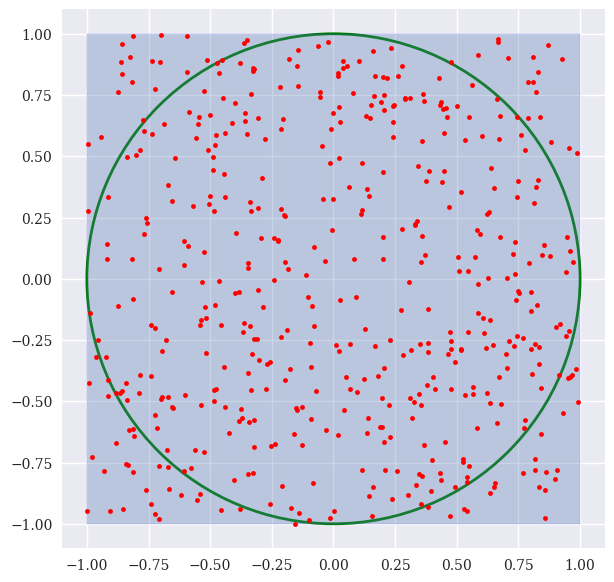

In [72]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
circ = plt.Circle((0, 0), radius=1, edgecolor='g',
                  lw=2.0, facecolor='None') # 단위원 그림
box = plt.Rectangle((-1, -1), 2, 2, edgecolor='b', alpha=0.3) # 변의 길이가 2인 정사각형 그림
ax.add_patch(circ)
ax.add_patch(box)
plt.plot(rn[:, 0], rn[:, 1], 'r.') # 난수 점을 균일하게 그림
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)

이 알고리즘을 넘파이로 구현하면 간결하지만 메모리를 많이 차지합니다. 전체 실행 시간은 약 1초입니다.

In [73]:
n = int(1e7)

In [74]:
%time rn = np.random.random((n, 2)) * 2 - 1

CPU times: total: 281 ms
Wall time: 286 ms


In [75]:
rn.nbytes

160000000

In [76]:
%time distance = np.sqrt((rn ** 2).sum(axis=1)) # 원점에서 점까지의 거리(유클리드 놈)
distance[:8].round(3)

CPU times: total: 188 ms
Wall time: 189 ms


array([0.265, 0.736, 0.928, 1.215, 0.6  , 0.434, 1.02 , 0.611])

In [77]:
%time frac = (distance <= 1.0).sum() / len(distance) # 단위원과 거리의 비율

CPU times: total: 15.6 ms
Wall time: 17.3 ms


In [78]:
# 정사각형 면적 4와 원 면적 추정, 즉 원주율
pi_mcs = frac * 4
pi_mcs

3.1413604

`mcs_pi_py()` 함수는 `for` 루프를 사용하여 메모리를 절약하는 방식으로 몬테카를로를 구현한 파이썬 함수입니다. 이 경우에는 난수가 스케일되어 있지 않고 실행 시간은 넘파이 버전보다 깁니다. `Numba` 버전은 넘파이 버전보다 빠르죠.

In [79]:
def mcs_pi_py(n):
    circle = 0
    for _ in range(n):
        x, y = random.random(), random.random()
        if (x ** 2 + y ** 2) ** 0.5 <= 1:
            circle += 1
    return (4 * circle) / n

In [80]:
%time mcs_pi_py(n)

CPU times: total: 5.81 s
Wall time: 5.88 s


3.140582

In [81]:
mcs_pi_nb = numba.jit(mcs_pi_py)

In [82]:
%time mcs_pi_nb(n) # 첫 컴파일

CPU times: total: 344 ms
Wall time: 342 ms


3.141922

In [83]:
%time mcs_pi_nb(n)

CPU times: total: 125 ms
Wall time: 128 ms


3.141386

정적 자료형 선언만 한 단순한 `Cython` 버전은 파이썬 버전보다 빠르지 않습니다. 하지만 C의 난수 생성 기능을 사용하면 훨씬 속도를 향상시킬 수 있습니다.

In [84]:
%%cython -a
import random
def mcs_pi_cy1(int n):
    cdef int i, circle = 0
    cdef float x, y
    for i in range(n):
        x, y = random.random(), random.random()
        if (x ** 2 + y ** 2) ** 0.5 <= 1:
            circle += 1
    return (4 * circle) / n

In [85]:
%time mcs_pi_cy1(n)

CPU times: total: 1.36 s
Wall time: 1.36 s


3.1415936

In [86]:
%%cython -a
from libc.stdlib cimport rand
cdef extern from 'limits.h':
    int INT_MAX
def mcs_pi_cy2(n):
    cdef int i, circle = 0
    cdef float x, y
    for i in range(n):
        x, y = rand() / INT_MAX, rand() / INT_MAX
        if (x ** 2 + y ** 2) ** 0.5 <= 1:
            circle += 1
    return (4 * circle) / n

In [87]:
%time mcs_pi_cy2(n)

CPU times: total: 906 ms
Wall time: 913 ms


4.0

> **NOTE**_ 알고리즘 유형  
이 절에서 분석한 알고리즘들은 금융 알고리즘과 직접 연관되어 있지는 않습니다. 하지만 간단하고 이해하기 쉽다는 장점이 있습니다. 또한 금융 분야에서 보게 되는 전형적인 알고리즘 문제들도 이런 간단한 맥락에서 논의할 수 있습니다.  

## 10.3 이항트리
옵션 가치를 평가할 때 인기 있는 수치해석 방법은 콕스(Cox), 로스(Ross), 루빈스타인(Rubinstein)이 1979년에 만든 이항 옵션 가치 모형입니다. 이 방법은 자신의 미래가치를 트리 형태로 표현하는 방법입니다. 이 모형에서는 블랙-숄즈-머튼(Black-Scholz-Murton) 모형처럼 지수나 주식 같은 위험 자산과 채권 같은 무위험 자산을 가정합니다.  
현 시점에서 옵션 만기까지의 상대적인 시간 구간을 길이 $\Delta t$ 라는 동일한 구간으로 나눕니다. 시간 $s$ 시점의 주가 수준을 $S_s$라 하고, $t=s+\Delta t$ 시점에서의 주가 수준을 $S_t = S_s\times m$이라 합니다. 여기에서 $m$은 $u$, $d$ 값 중 하나이면, $u$, $d$는 다음과 같이 정의합니다.  
$$0<d<e^{r\Delta t}<u=e^{\sigma\sqrt{\Delta t}}$$  
($u=\frac{1}{d}$, $r$: 무위험 단기 이자율, 상수)  

### 10.3.1 파이썬
다음 코드는 모형의 매개변수 값에 기반하여 트리를 생성하는 파이썬 구현입니다.

In [88]:
import math

In [89]:
S0= 36. # 위험 자산의 초기값
T = 1.0 # 이항트리 시뮬레이션의 시간 구간
r = 0.06 # 상수 이자율
sigma = 0.2 # 상수 변동성

In [90]:
def simulate_tree(M):
    dt = T / M
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    S = np.zeros((M + 1, M + 1))
    S[0, 0] = S0
    z = 1
    for t in range(1, M + 1):
        for i in range(z):
            S[i, t] = S[i, t - 1] * u
            S[i + 1, t] = S[i, t-1] * d
        z += 1
    return S

전형적인 트리 플롯에서 보이는 것과 달리 상승 움직임을 `ndarray` 객체에서 옆으로 놓게 되면 `ndarray`의 크기를 크게 줄일 수 있습니다.

In [91]:
np.set_printoptions(formatter={'float': lambda x: '%6.2f' % x})

In [92]:
simulate_tree(4) # 구간이 4개인 트리

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]])

In [93]:
%time simulate_tree(500) # 구간이 500개인 트리

CPU times: total: 93.8 ms
Wall time: 96.3 ms


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [  0.00,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [  0.00,   0.00,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]])

### 10.3.2 NumPy
약간의 트릭을 쓰면 이 이항트리를 완전히 벡터화된 형태의 넘파이로 생성할 수 있습니다.

In [94]:
M = 4

In [95]:
# 전체 상승 움직임을 나타내는 ndarray 객체
up = np.arange(M + 1)
up = np.resize(up, (M + 1, M + 1))
up

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [96]:
# 전체 하락 움직임을 나타내는 ndarray 객체
down = up.T * 2
down

array([[0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2],
       [4, 4, 4, 4, 4],
       [6, 6, 6, 6, 6],
       [8, 8, 8, 8, 8]])

In [97]:
up - down # 순수 상승 및 하락 움직임을 나타내는 ndarray 객체

array([[ 0,  1,  2,  3,  4],
       [-2, -1,  0,  1,  2],
       [-4, -3, -2, -1,  0],
       [-6, -5, -4, -3, -2],
       [-8, -7, -6, -5, -4]])

In [98]:
dt = T / M

In [99]:
S0 * np.exp(sigma * math.sqrt(dt) * (up - down)) # 4개의 시간 구간용 트리

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [ 29.47,  32.57,  36.00,  39.79,  43.97],
       [ 24.13,  26.67,  29.47,  32.57,  36.00],
       [ 19.76,  21.84,  24.13,  26.67,  29.47],
       [ 16.18,  17.88,  19.76,  21.84,  24.13]])

넘파이의 경우에는 코드가 비교적 간단합니다. 하지만 더 중요한 것은 넘파이 벡터화로 인해 많은 메모리를 사용하지 않고도 속도를 향상시킬 수 있다는 것입니다.

In [100]:
def simulate_tree_np(M):
    dt = T / M
    up = np.arange(M + 1)
    up = np.resize(up, (M + 1, M + 1))
    down = up.transpose() * 2
    S = S0 * np.exp(sigma * math.sqrt(dt) * (up - down))
    return S

In [101]:
simulate_tree_np(4)

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [ 29.47,  32.57,  36.00,  39.79,  43.97],
       [ 24.13,  26.67,  29.47,  32.57,  36.00],
       [ 19.76,  21.84,  24.13,  26.67,  29.47],
       [ 16.18,  17.88,  19.76,  21.84,  24.13]])

In [102]:
%time simulate_tree_np(500)

CPU times: total: 0 ns
Wall time: 6.61 ms


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [ 35.36,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [ 34.73,  35.05,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.41,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.40,   0.41,   0.41]])

### 10.3.3 Numba
이 금융 알고리즘은 `Numba` 동적 컴파일을 통한 최적화에 매우 적합해야 합니다. 그리고 실제로 넘파이 버전보다도 큰 성능 향상이 관찰됩니다. 이로 인해 이 `Numba` 버전은 원래 파이썬 버전보다 수십 배 빨라졌습니다.

In [103]:
simulate_tree_nb = numba.jit(simulate_tree)

In [104]:
simulate_tree_nb(4)

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]])

In [105]:
%time simulate_tree_nb(500)

CPU times: total: 0 ns
Wall time: 849 µs


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [  0.00,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [  0.00,   0.00,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]])

In [106]:
%time simulate_tree_nb(500)

CPU times: total: 0 ns
Wall time: 428 µs


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [  0.00,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [  0.00,   0.00,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]])

### 10.3.4 Cython
이전과 마찬가지로 `Cython`을 사용하여 속도를 향상하려면 코드를 고쳐야 합니다. 다음 버전은 주로 정적 자료형 선언을 사용하고 일반 파이썬 임포트에 비해 성능이 좋은 다른 임포트를 한 것입니다.

In [107]:
%%cython -a
import numpy as np
cimport cython
from libc.math cimport exp, sqrt
cdef float S0 = 36.
cdef float T = 1.0
cdef float r = 0.06
cdef float sigma = 0.2
def simulate_tree_cy(int M):
    cdef int z, t, i
    cdef float dt, u, d
    cdef float[:, :] S = np.zeros((M + 1, M + 1),
                                  dtype=np.float32) # 속도에 영향을 미치는 ndarray 객체를 C 배열로 선언
    dt = T / M
    u = exp(sigma * sqrt(dt))
    d = 1 / u
    S[0, 0] = S0
    z = 1
    for t in range(1, M + 1):
        for i in range(z):
            S[i, t] = S[i, t-1] * u
            S[i+1, t] = S[i, t-1] * d
        z += 1
    return np.array(S)

In [108]:
simulate_tree_cy(4)

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]], dtype=float32)

In [109]:
%time simulate_tree_cy(500)

CPU times: total: 0 ns
Wall time: 1.49 ms


array([[ 36.00,  36.32,  36.65, ..., 3095.77, 3123.59, 3151.65],
       [  0.00,  35.68,  36.00, ..., 3040.89, 3068.21, 3095.77],
       [  0.00,   0.00,  35.36, ..., 2986.97, 3013.81, 3040.89],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]],
      dtype=float32)

In [110]:
%timeit S = simulate_tree_cy(500)

652 µs ± 48.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### 10.1.4 몬테카를로 시뮬레이션
몬테카를로 시뮬레이션은 계산 금융학에서 빠질 수 없는 수치적 도구이며 현대의 컴퓨터가 등장하기 전부터 사용되어 왔습니다. 은행이나 다른 금융기관은 가격결정을 하거나 위험 관리를 하는 데 몬테카를로 시뮬레이션을 사용합니다. 이 방법은 금융에서 가장 유연하고 강력한 방법 중 하나지만 가장 계산량이 많은 방법이기도 합니다. 그래서 몬테카를로 시뮬레이션을 구현하는 데 파이썬은 (최소한 실무 응용 분야에서는) 적절한 프로그래밍 언어가 아니라고 여겨져 왔습니다.  
이 절에서는 기하 브라운 운동에 대한 몬테카를로 시뮬레이션을 분석합니다. 기하 브라운 운동은 주가나 지수의 움직임을 모형화하는 확률 과정으로 널리 사용됩니다.  
무엇보다 블랙-숄즈-머튼 옵션 가격결정 이론은 이 확률 과정에 기반하고 있습니다. 이 이론은 옵션의 기초 자산인 주식의 가격이 다음 수식에서 보여주는 확률적 미분방정식(stochastic differential equation)을 따른다고 가정합니다. 이 식에서 $S_t$는 $t$ 시점의 기초 자산의 가격, $r$은 상수로 무위험 이자율, $\sigma$ 역시 상수로 순간 변동성, $Z_t$는 브라운 운동을 의미합니다.  
$$\mathrm{d}S_t=rS_t\mathrm{d}t+\sigma S_t\mathrm{d}Z_t$$  
이 확률적 미분방정식을 동일한 시간 구간으로 나누어 오일러 이산화 방식을 적용하면 아래와 같습니다. 여기에서 $z$는 표준정규분포 난수입니다. 시뮬레이션 전체 시간(평가 대상 옵션의 만기일)이 $T$고 구간 길이가 $\Delta t=\frac{T}{M}$인 $M$개의 시간 구간으로 나누었습니다.  
$$S_t=S_{t-\Delta t}\mathrm{exp}\left(\left(r-\frac{\sigma^2}{2}\right)\Delta t+\sigma\sqrt{\Delta t}z\right)$$  
유러피안 콜 옵션에 대한 몬테카를로 추정치는 아래와 같습니다. 여기에서 $S_T$는 만기 $T$까지의 주가 시뮬레이션 값으로 $I$개의 경로로 시뮬레이션했습니다($i=1, 2, \cdots, I$).  
$$C_U=e^{-rT}\frac{1}{I}\sum_i \max \left(S_T\left(i\right)-K, 0\right)$$

### 10.4.1 파이썬
우선 두번째 수식에 따라 몬테카를로 시뮬레이션을 구현한 파이썬 함수는 `mcs_simulation_py()`입니다. 이 함수는 `ndarray` 객체에 대해 파이썬 루프를 구현했기 때문에 복합적인 방법이라 할 수 있습니다. 이렇게 하면 앞에서처럼 `Numba`로 코드를 동적 컴파일하기 쉬워집니다. 마찬가지로 이때의 실행 속도를 벤치마크 기준으로 놓습니다. 시뮬레이션에 따르면 유러피안 풋 옵션의 가치도 계산됩니다.

In [111]:
M = 100 # 이산화 시간 구간의 개수
I = 50000 # 시뮬레이션할 경로의 개수

In [112]:
def mcs_simulation_py(p):
    M, I = p
    dt = T / M
    S = np.zeros((M + 1, I))
    S[0] = S0
    rn = np.random.standard_normal(S.shape) # 벡터화 방법으로 구한 난수 집합
    
    # 오일러 방식 시뮬레이션에 기반한 중첩 루프 구현
    for t in range(1, M + 1):
        for i in range(I):
            S[t, i] = S[t-1, i] * math.exp((r - sigma ** 2 / 2) * dt +
                                           sigma * math.sqrt(dt) * rn[t, i])
    return S

In [113]:
%time S = mcs_simulation_py((M, I))

CPU times: total: 8.23 s
Wall time: 8.44 s


In [114]:
S[-1].mean() # 시뮬레이션에 기반한 만기 값의 평균

38.18762237097228

In [115]:
S0 * math.exp(r * T) # 만기 값의 이론적 기대값

38.22611567563295

In [116]:
K = 40. # 유러피안 풋 옵션의 행사가

In [117]:
C0 = math.exp(-r * T) * np.maximum(K - S[-1], 0).mean() # 옵션에 대한 몬테카를로 추정치

In [118]:
C0

3.8532132363596534

아래 그림은 유러피안 풋 옵션 만기 시점의 시뮬레이션 결과값 히스토그램입니다.

### 10.4.2 NumPy
넘파이 버전인 `mcs_simulation_np()` 함수도 크게 다르지 않습니다. 여전히 시간 구간을 돌아가는 하나의 파이썬 루프를 사용합니다. 경로에 대한 차원은 벡터화된 코드를 사용합니다. 이러면 이전 버전보다도 약 20배 빠릅니다.

In [119]:
def mcs_simulation_np(p):
    M, I = p
    dt = T / M
    S = np.zeros((M+1, 1))
    S[0] = S0
    rn = np.random.standard_normal(S.shape)
    for t in range(1, M+1): # 시간 구간에 대한 루프
        # 오일러 방식으로 모든 경로를 한 번에 처리합니다.
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + 
                               sigma * math.sqrt(dt) * rn[t])
    return S

In [120]:
%time S = mcs_simulation_np((M, I))

CPU times: total: 15.6 ms
Wall time: 6.61 ms


In [121]:
S[-1].mean()

28.231368559457305

In [122]:
%timeit S = mcs_simulation_np((M, I))

580 µs ± 52.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### 10.4.3 Numba
이제는 `Numba`를 이런 알고리즘에 쉽게 적용하여 속도를 개선할 수 있다는 게 놀랍지도 않죠? `Numba` 버전인 `mcs_simulation_nb()` 함수는 넘파이 버전보다 조금 빠릅니다.

In [123]:
mcs_simulation_nb = numba.jit(mcs_simulation_py)

In [124]:
%time S = mcs_simulation_nb((M, I))

CPU times: total: 906 ms
Wall time: 984 ms


In [125]:
%time S = mcs_simulation_nb((M, I))

CPU times: total: 250 ms
Wall time: 277 ms


In [126]:
S[-1].mean()

38.21024111992012

In [127]:
C0 = math.exp(-r * T) * np.maximum(K - S[-1], 0).mean()

In [128]:
C0

3.8544808144030616

In [129]:
%timeit S = mcs_simulation_nb((M, I))

192 ms ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 10.4.4 Cython
놀라운 일은 아니지만 `Cython`을 쓰면 코드 속도를 높이는 데 추가적인 노력이 필요합니다. 하지만 속도 향상 자체는 그렇게 크지 않습니다. `Cython` 버전인 `mcs_simulation_cy()` 함수는 넘파이 또는 `Numba` 버전에 비해 약간 느립니다. 다른 요소보다 시뮬레이션 결과를 `ndarray` 배열로 바꾸는 데 시간이 필요합니다.

In [130]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp, sqrt
cdef float S0 = 36.
cdef float T = 1.0
cdef float r = 0.06
cdef float sigma = 0.2
@cython.boundscheck(False)
@cython.wraparound(False)
def mcs_simulation_cy(p):
    cdef int M, I
    M, I = p
    cdef int t, i
    cdef float dt = T / M
    cdef double[:, :] S = np.zeros((M + 1, I))
    cdef double[:, :] rn = np.random.standard_normal((M + 1, I))
    S[0] = S0
    for t in range(1, M+1):
        for i in range(I):
            S[t, i] = S[t-1, i] * exp((r - sigma ** 2 / 2) * dt +
                                      sigma * sqrt(dt) * rn[t, i])
    
    return np.array(S)

In [131]:
%time S = mcs_simulation_cy((M, I))

CPU times: total: 219 ms
Wall time: 217 ms


In [132]:
S[-1].mean()

38.2037872817128

In [133]:
%timeit S = mcs_simulation_cy((M, I))

202 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 10.4.5 멀티프로세싱
몬테카를로 시뮬레이션은 병렬화에 적합한 작업입니다. 한 가지 방법은 10만 개의 경로를 10개의 프로세스에 나누어 병렬적으로 시뮬레이션하는 것입니다. 또 다른 방법은 경로 자체는 동일하게 하고 다른 금융 상품을 동시에 가치 평가하는 것입니다. 전자의 경우는 일정한 수의 분리된 프로세스에서 대량의 경로를 병렬적으로 시뮬레이션하는 것으로, 다음 코드에 설명되어 있습니다. 이 코드도 `multiprocessing` 모듈을 사용합니다. 시뮬레이션할 경로의 전체 개수 $I$를 $I/p$ ($p>0$) 개수로 나눕니다. 작업이 완료되면 결과는 `np.hstack()` 명령으로 하나의 `ndarray` 객체에 넣습니다. 이 방식은 지금까지 설명한 어떤 버전의 코드에도 적용할 수 있습니다. 이 코드에서 사용한 매개변수 값의 경우에는 병렬화로 인한 성능 개선이 눈에 띄지 않습니다.

In [134]:
import multiprocessing as mp

In [135]:
pool = mp.Pool(processes=4) # 병렬화용 Pool 객체

In [136]:
p = 20 # 시뮬레이션을 나눈 조각의 개수

In [137]:
# inputs = p * [(M, int(I / p))]
# S = np.hstack(pool.map(mcs_simulation_np, inputs))
# pool.close()
# pool.join()

# # 결과 출력 등 추가 작업을 진행합니다.
# print(S)

In [138]:
# %timeit S = np.hstack(pool.map(mcs_simulation_nb, p * [(M, int(I / p))]))

In [139]:
# %timeit S = np.hstack(pool.map(mcs_simulation_cy, p * [(M, int(I / p))]))

> **TIP** 멀티프로세싱 전략  
금융에는 병렬화에 적합한 알고리즘이 많습니다. 코드를 병렬화하기 위한 전략 자체도 여러 가지이고요. 몬테카를로 시뮬레이션은 단일 머신이나 복수의 머신에서 병렬화하기 쉬운 좋은 예입니다. 그리고 몬테카를로 시뮬레이션 알고리즘 자체도 하나의 시뮬레이션을 복수의 프로세스에 병렬화할 수 있습니다.  

## 10.5 재귀적 pandas 알고리즘
이 절에서는 조금 특별한, 금융 분석에서 중요한 주제를 다루겠습니다. 판다스 `DataFrame` 객체에 저장된 금융 시계열에 재귀적 함수를 구현하는 것ㅇ비니다. 판다스 자체가 `DataFrame` 객체에 대한 복잡한 벡터화 연산을 허용하지만 어떤 종류의 재귀적 알고리즘은 벡터화해서 구현하기가 어렵기 때문에 금융 분석가들은 `DataFrame` 객체에 느린 파이썬 루프를 적용하고는 합니다. 이 예제에서는 **지수가중 이동평균**(Exponentially Weighted Moving Average, EWMA)이라고 부르는 것을 간단한 형태로 구현하겠습니다.  
금융 시계열 $S_t,t\in \left\{0, \cdots, T\right\}$에 대한 지수가동 이동평균은 아래 수식과 같습니다.  
$$EWMA_0=S_0$$  
$$EWMA_t=\alpha\cdot S_t\left(1-\alpha\right)\cdot EWMA_{t-1},t\in\left\{1, \cdots, T\right\}$$  
수식이 단순하고 구현도 간단하지만 이 알고리즘은 코드가 ~~더럽게~~ 느려집니다.
### 10.5.1 파이썬
우선 금융 상품의 금융 시계열 데이터를 가진 `DataFrame` 객체의 `DatetimeIndex`에 대해 반복 작업을 하는 파이썬 버전을 생각해보겠습니다(8장 참조). 아래 그림이 금융 시계열과 EWMA 시계열입니다.

In [140]:
import pandas as pd

In [141]:
sym = 'SPY'

In [142]:
data = pd.DataFrame(pd.read_csv('tr_eikon_eod_data.csv',
                                index_col=0, parse_dates=True)[sym]).dropna()

In [143]:
alpha = 0.25

In [144]:
data['EWMA'] = data[sym] # EWMA 열 초기화

In [147]:
%%time
for t in zip(data.index, data.index[1:]):
    # 파이썬 루프 기반 알고리즘
    data.loc[t[1], 'EWMA'] = (alpha * data.loc[t[1], sym] +
                              (1 - alpha) * data.loc[t[0], 'EWMA'])

CPU times: total: 359 ms
Wall time: 354 ms


In [148]:
data.head()

,SPY,EWMA
Date,,
2010-01-04,113.33,113.330000
2010-01-05,113.63,113.405000
2010-01-06,113.71,113.481250
2010-01-07,114.19,113.658438
2010-01-08,114.57,113.886328


<Axes: xlabel='Date'>

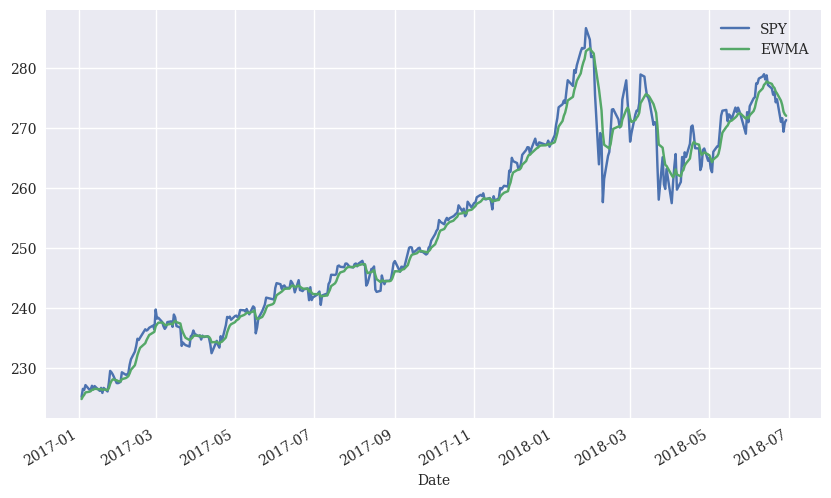

In [149]:
data[data.index > '2017-1-1'].plot(figsize=(10, 6))

이제 좀 더 일반적인 파이썬 함수 `ewma_py()`를 고려합니다. 이 함수는 원본 금융 시계열 데이터 `ndarray` 객체나 열에 바로 적용할 수 있습니다.

In [150]:
def ewma_py(x, alpha):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] +(1-alpha) * y[i-1]
    return y

In [151]:
%time data['EWMA_PY'] = ewma_py(data[sym], alpha) # 함수를 Series 객체(열)에 직접 적용

CPU times: total: 15.6 ms
Wall time: 9.54 ms


In [152]:
%time data['EWMA_PY'] = ewma_py(data[sym].values, alpha) # 함수를 원본 데이터를 가진 ndarray 객체에 적용

CPU times: total: 0 ns
Wall time: 1.47 ms


이 방식은 코드 실행 속도를 20배에서 100배까지 계산합니다.
### 10.5.2 Numba
알고리즘 구조상 `Numba`를 적용하면 좀 더 속도 개선을 할 수 있습니다. 그리고 실제로 `ndarray` 버전에 적용한 함수 `ewma_nb()`에서는 속도 개선이 가능했습니다.

In [153]:
ewma_nb = numba.jit(ewma_py)

In [154]:
%time data['EWMA_NB'] = ewma_nb(data[sym], alpha)

C:\Users\tjk\AppData\Local\Temp\ipykernel_10568\2003121273.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "ewma_py" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\tjk\AppData\Local\Temp\ipykernel_10568\2003121273.py (2)

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_10568\2003121273.py", line 2:
<source missing, REPL/exec in use?>

  def ewma_py(x, alpha):
C:\Users\tjk\AppData\Local\Temp\ipykernel_10568\2003121273.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "ewma_py" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_10568\2003121273.py", line 4:
<source missing, REPL/exec in use?>

  def ewma_py(x, alpha):
c:\Users\tjk\AppData\Local\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning

CPU times: total: 391 ms
Wall time: 398 ms


c:\Users\tjk\AppData\Local\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "ewma_py" was compiled in object mode without forceobj=True.

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_10568\2003121273.py", line 4:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
c:\Users\tjk\AppData\Local\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_10568\2003121273.py", line 4:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaDeprecationWarning(msg,


In [156]:
%timeit data['EWMA_NB'] = ewma_nb(data[sym], alpha)

5.14 ms ± 523 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [157]:
%time data['EWMA_NB'] = ewma_nb(data[sym].values, alpha)

CPU times: total: 312 ms
Wall time: 322 ms


In [158]:
%timeit data['EWMA_NB'] = ewma_nb(data[sym].values, alpha)

56.7 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### 10.5.3 Cython
`Cython` 버전 `ewma_cy()` 함수도 이 경우에는 `Numba` 버전만큼 빠르지는 않지만 역시 속도 개선이 가능합니다.

In [159]:
%%cython
import numpy as np
cimport cython
@cython.boundscheck(False)
@cython.wraparound(False)
def ewma_cy(double[:] x, float alpha):
    cdef int i
    cdef double[:] y = np.empty_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1-alpha) * y[i - 1]
    return y

In [160]:
%time data['EWMA_CY'] = ewma_cy(data[sym].values, alpha)

CPU times: total: 0 ns
Wall time: 129 µs


In [161]:
%timeit data['EWMA_CY'] = ewma_cy(data[sym].values, alpha)

85.7 µs ± 7.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


이 마지막 예제는 비표준적인 알고리즘을 구현하는 데에도 여러 가지 방법이 가능하다는 것을 보여줍니다. 모든 방법의 결과는 같지만, 성능 특성은 저마다 다릅니다. 실행 시간의 경우 약 5000배까지 차이가 납니다.  
> **NOTE**_ 최고와 빨리  
알고리즘을 파이썬 프로그래밍 언어로 번역하는 것은 보통 아주 쉽습니다. 하지만 성능 측면에서 불필요하게 느린 형태로 알고리즘을 구현하기도 쉽다는 문제가 있죠. 상호작용적인 금융 분석에서는 빨리 만들 수 있는 방법, 즉 가장 빠르지 않거나 메모리를 많이 소모하는 방법이라도 괜찮습니다. 하지만 생산 단계에 사용하는 금융 애플리케이션에서는 최고의 방법을 찾아서 구현해야 합니다. 이렇게 하려면 연구도 필요하고 형식적인 벤치마킹도 필요합니다.

## 10.6 마치며
파이썬 생태계는 코드의 성능을 향상시키는 여러 가지 방법을 제공합니다.  
* 패러다임: 어떤 종류의 파이썬 패러다임은 특정 문제에 대해 다른 것보다 성능이 뛰어납니다.
* 패키지: 여러 가지 다른 유형의 문제에 대해 다양한 패키지가 구비되어 있으므로 문제에 적합한 패키지를 사용하면 훨씬 뛰어난 성능을 이끌어낼 수 있습니다. 좋은 예가 `ndarray` 클래스와 `DataFrame` 클래스를 넘파이 패키지와 함께 사용하는 것입니다.
* 컴파일: `Numba`나 `Cython`과 같이 파이썬 코드를 동적 혹은 정적으로 컴파일하는 강력한 패키지를 사용하면 금융 알고리즘의 속도를 빠르게 할 수 있습니다.
* 병렬화: `multiprocessing`과 같은 파이썬 패키지를 사용하면 파이썬 코드를 쉽게 병렬화할 수 있습니다. 이 장의 예제에서는 단일 머신에 대한 병렬화만 살펴봤지만, 파이썬 생태계는 클러스터 병렬화 기술도 제공합니다.  

이 장에 소개된 성능 개선 방법의 큰 장점은 구현하기 쉽다는 것이고, 추가 노력이 많이 들지 않는다는 것입니다. 즉, 최신 패키지만 있으면 ~~그리고 약간의 두뇌 과부하가 있으면~~ 성능 개선은 식은 죽 먹기입니다.